# Generate land/water training data on Sentinel-1 data using Sentinel-2 data

## Install tools from coastlines repository

In [1]:
# pip install -q git+https://github.com/digitalearthafrica/deafrica-coastlines.git --disable-pip-version-check

## Load packages

In [2]:
import os
os.environ['USE_PYGEOS'] = '0'

import datacube
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.ops import nearest_points

from deafrica_tools.datahandling import load_ard, mostcommon_crs
from deafrica_tools.bandindices import calculate_indices
from dea_tools.coastal import model_tides, tidal_tag, pixel_tides, tidal_stats
from dea_tools.spatial import subpixel_contours
from deafrica_tools.plotting import display_map, rgb, map_shapefile
from deafrica_tools.dask import create_local_dask_cluster

from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance
from skimage.filters import threshold_minimum, threshold_otsu
from skimage.morphology import binary_dilation,disk
import random
import pickle

from modules import lee_filter,filter_by_tide_height,load_s1_by_orbits,process_features_s1,create_coastal_mask,collect_training_samples

/tmp/ipykernel_5753/2522696629.py:19: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import uniform_filter
/tmp/ipykernel_5753/2522696629.py:20: DeprecationWarning: Please use `variance` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  from scipy.ndimage.measurements import variance


## Set up a Dask cluster

In [3]:
client = create_local_dask_cluster(return_client=True)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/whusggliuqx@gmail.com/proxy/8787/status,
Dashboard: /user/whusggliuqx@gmail.com/proxy/8787/status,Workers: 1
Total threads: 4,Total memory: 26.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41337,Workers: 1
Dashboard: /user/whusggliuqx@gmail.com/proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 26.21 GiB
Comm: tcp://127.0.0.1:37943,Total threads: 4
Dashboard: /user/whusggliuqx@gmail.com/proxy/44545/status,Memory: 26.21 GiB
Nanny: tcp://127.0.0.1:43589,


## Connect to the datacube

In [4]:
dc = datacube.Datacube(app="Sentinel-1 land water training data extraction")

## Define parameters

In [5]:
# Define areas of interest
locations={'Madagascar_west':(-17.474,43.924),
           'Madagascar_south':(-25.572,45.538),
           'Tanzania':(-6.32,39.280),
           'Kenya':(-4.025,39.725),
           'Comoros':(-12.4,43.736)
          }

# Set the range of dates for the analysis, time step and tide range
time_range = ('2018', '2021')
time_step = '1Y'
tide_range = (0.25, 0.75)

# whether to apply orbit filtering
s1_orbit_filtering=True

# Lee filtering size
filter_size=None

# maximum number of samples per location
max_samples=10000

out_folder='data'
if not os.path.exists(out_folder):
    os.makedirs(out_folder)

## Export defined study locations as geojson

In [6]:
df=pd.DataFrame({'Location':list(locations.keys()),
                 'Lon':[locations[location_name][1] for location_name in locations],
                 'Lat':[locations[location_name][0] for location_name in locations]})
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.Lon, df.Lat), crs="EPSG:4326"
)
gdf.to_file(os.path.join(out_folder,'locations.geojson'), driver='GeoJSON')

## Collect training data for all locations


Querying and loading Sentinel-1 ascending data...
Using pixel quality parameters for Sentinel 1
Finding datasets
    s1_rtc
Applying pixel quality/cloud mask
Returning 1 time steps as a dask array

Querying and loading Sentinel-1 descending data...
Using pixel quality parameters for Sentinel 1
Finding datasets
    s1_rtc
Applying pixel quality/cloud mask
Returning 145 time steps as a dask array
Tide modelling and filtering for Sentinel-1...
Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides using FES2014 tide model
Reprojecting tides into original array


100%|██████████| 146/146 [00:00<00:00, 177.32it/s]



Filtering Sentinel-1 product by orbit...


/usr/local/lib/python3.10/dist-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Calculating features for Sentinel-1
Generate temporal composites...

Querying Sentinel-2 data...
Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Counting good quality pixels for each time step
Filtering to 198 out of 288 time steps with at least 80.0% good quality pixels
Applying morphological filters to pq mask [('opening', 2), ('dilation', 5)]
Applying pixel quality/cloud mask
Returning 198 time steps as a dask array
Tide modelling and filtering for Sentinel-2...
Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides using FES2014 tide model
Reprojecting tides into original array


100%|██████████| 198/198 [00:01<00:00, 182.50it/s]



Calculating simplified coastal zone mask...

Applying buffering of 10 Sentinel-2 pixels (parameter buffer_pixels)...

Number of samples available:  167446
Saving data...

Querying and loading Sentinel-1 ascending data...
Using pixel quality parameters for Sentinel 1
Finding datasets
    s1_rtc
Applying pixel quality/cloud mask
Returning 3 time steps as a dask array

Querying and loading Sentinel-1 descending data...
Using pixel quality parameters for Sentinel 1
Finding datasets
    s1_rtc
Applying pixel quality/cloud mask
Returning 116 time steps as a dask array
Tide modelling and filtering for Sentinel-1...
Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides using FES2014 tide model
Reprojecting tides into original array


100%|██████████| 119/119 [00:00<00:00, 182.49it/s]



Filtering Sentinel-1 product by orbit...
Calculating features for Sentinel-1
Generate temporal composites...

Querying Sentinel-2 data...
Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Counting good quality pixels for each time step
Filtering to 364 out of 574 time steps with at least 80.0% good quality pixels
Applying morphological filters to pq mask [('opening', 2), ('dilation', 5)]
Applying pixel quality/cloud mask
Returning 364 time steps as a dask array
Tide modelling and filtering for Sentinel-2...
Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides using FES2014 tide model
Reprojecting tides into original array


100%|██████████| 364/364 [00:01<00:00, 189.83it/s]



Calculating simplified coastal zone mask...

Applying buffering of 10 Sentinel-2 pixels (parameter buffer_pixels)...

Number of samples available:  36048
Saving data...

Querying and loading Sentinel-1 ascending data...
Using pixel quality parameters for Sentinel 1
Finding datasets
    s1_rtc
Applying pixel quality/cloud mask
Returning 118 time steps as a dask array

Querying and loading Sentinel-1 descending data...
Using pixel quality parameters for Sentinel 1
Finding datasets
    s1_rtc
Applying pixel quality/cloud mask
Returning 55 time steps as a dask array
Tide modelling and filtering for Sentinel-1...
Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides using FES2014 tide model
Reprojecting tides into original array


100%|██████████| 173/173 [00:01<00:00, 171.97it/s]



Filtering Sentinel-1 product by orbit...
Calculating features for Sentinel-1
Generate temporal composites...

Querying Sentinel-2 data...
Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Counting good quality pixels for each time step
Filtering to 133 out of 286 time steps with at least 80.0% good quality pixels
Applying morphological filters to pq mask [('opening', 2), ('dilation', 5)]
Applying pixel quality/cloud mask
Returning 133 time steps as a dask array
Tide modelling and filtering for Sentinel-2...
Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides using FES2014 tide model
Reprojecting tides into original array


100%|██████████| 133/133 [00:00<00:00, 171.69it/s]



Calculating simplified coastal zone mask...

Applying buffering of 10 Sentinel-2 pixels (parameter buffer_pixels)...

Number of samples available:  71875
Saving data...

Querying and loading Sentinel-1 ascending data...
Using pixel quality parameters for Sentinel 1
Finding datasets
    s1_rtc
Applying pixel quality/cloud mask
Returning 121 time steps as a dask array

Querying and loading Sentinel-1 descending data...
Using pixel quality parameters for Sentinel 1
Finding datasets
    s1_rtc
Applying pixel quality/cloud mask
Returning 55 time steps as a dask array
Tide modelling and filtering for Sentinel-1...
Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides using FES2014 tide model
Reprojecting tides into original array


100%|██████████| 176/176 [00:01<00:00, 175.07it/s]



Filtering Sentinel-1 product by orbit...
Calculating features for Sentinel-1
Generate temporal composites...

Querying Sentinel-2 data...
Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Counting good quality pixels for each time step
Filtering to 146 out of 286 time steps with at least 80.0% good quality pixels
Applying morphological filters to pq mask [('opening', 2), ('dilation', 5)]
Applying pixel quality/cloud mask
Returning 146 time steps as a dask array
Tide modelling and filtering for Sentinel-2...
Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides using FES2014 tide model
Reprojecting tides into original array


100%|██████████| 146/146 [00:00<00:00, 173.90it/s]



Calculating simplified coastal zone mask...

Applying buffering of 10 Sentinel-2 pixels (parameter buffer_pixels)...

Number of samples available:  230068
Saving data...

Querying and loading Sentinel-1 ascending data...
Using pixel quality parameters for Sentinel 1
Finding datasets
    s1_rtc
Applying pixel quality/cloud mask
Returning 92 time steps as a dask array

Querying and loading Sentinel-1 descending data...
Using pixel quality parameters for Sentinel 1
Finding datasets
    s1_rtc
Applying pixel quality/cloud mask
Returning 99 time steps as a dask array
Tide modelling and filtering for Sentinel-1...
Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides using FES2014 tide model
Reprojecting tides into original array


100%|██████████| 191/191 [00:01<00:00, 176.82it/s]



Filtering Sentinel-1 product by orbit...
Calculating features for Sentinel-1
Generate temporal composites...

Querying Sentinel-2 data...
Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Counting good quality pixels for each time step
Filtering to 397 out of 578 time steps with at least 80.0% good quality pixels
Applying morphological filters to pq mask [('opening', 2), ('dilation', 5)]
Applying pixel quality/cloud mask
Returning 397 time steps as a dask array
Tide modelling and filtering for Sentinel-2...
Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides using FES2014 tide model
Reprojecting tides into original array


100%|██████████| 397/397 [00:02<00:00, 182.12it/s]
2023-08-16 03:15:03,277 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-08-16 03:15:43,347 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)



Calculating simplified coastal zone mask...

Applying buffering of 10 Sentinel-2 pixels (parameter buffer_pixels)...


2023-08-16 03:16:35,223 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-08-16 03:17:05,678 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-08-16 03:17:45,928 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)



Number of samples available:  130541
Saving data...


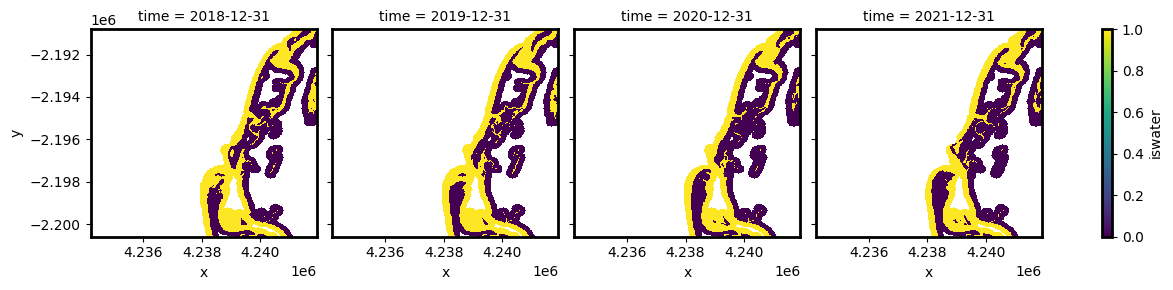

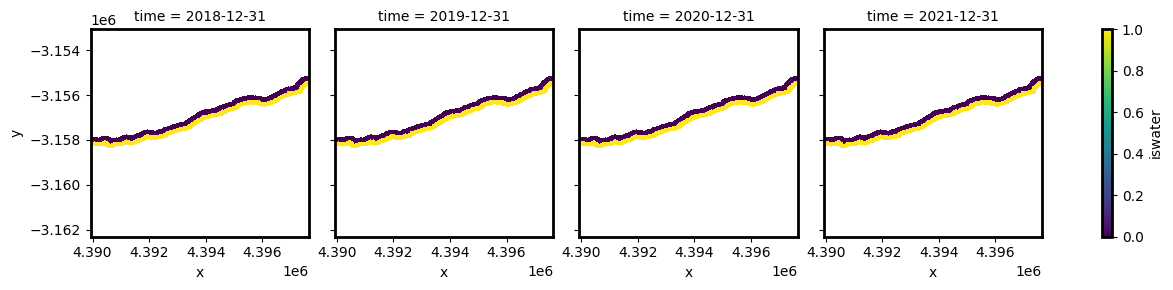

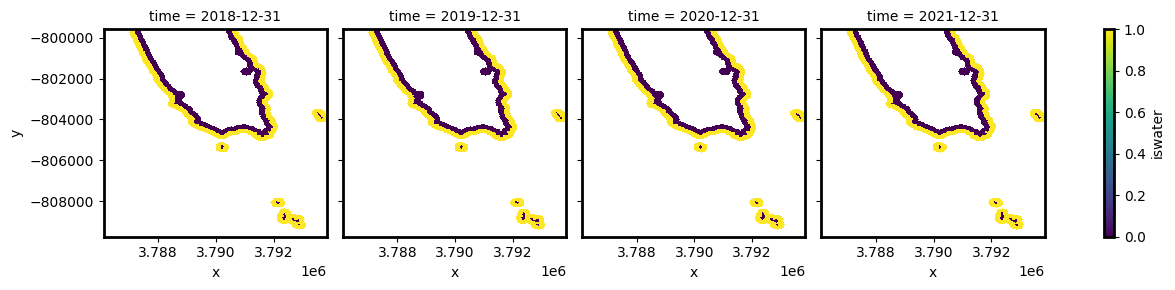

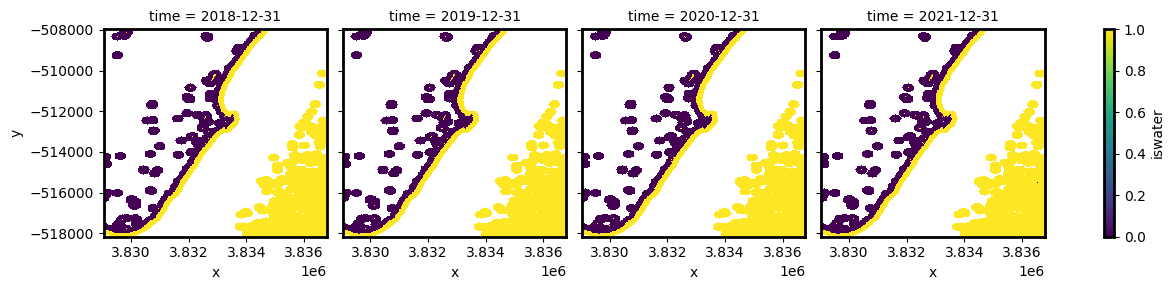

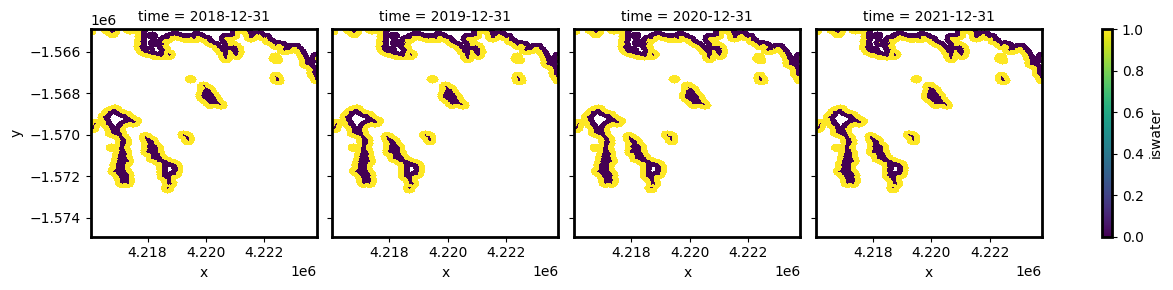

In [7]:
for location_name in locations:
    print('Collecting training data for location ',location_name)
    # define area of interest
    lat=locations[location_name][0]
    lon=locations[location_name][1]

    # Combine central lat,lon with buffer to get area of interest
    buffer = 0.04
    lat_range = (lat - buffer, lat + buffer)
    lon_range = (lon - buffer, lon + buffer)

    # query S1 data
    query = {
        'x': lon_range,
        'y': lat_range,
        'time': time_range,
        'measurements': ['vh','vv','angle','mask','area'], # loading vh for experiement
        'resolution': (-20, 20),
        'output_crs':"EPSG:6933",
        'group_by':'solar_day',
        'dask_chunks':{'time': 1}
    }

    # load s1 by orbit
    S1=load_s1_by_orbits(dc,query)

    # per-pixel tide modelling and filtering
    print('Tide modelling and filtering for Sentinel-1...')
    S1_filtered=filter_by_tide_height(S1,tide_centre=0.0)

    # preprocess S1 and extract features
    ds_summaries_s1=process_features_s1(S1_filtered,filter_size=filter_size,
                                    s1_orbit_filtering=s1_orbit_filtering,time_step=time_step)

    # save sentinel-1 feature names
    feature_names=list(ds_summaries_s1.keys())
    with open('s1_features', 'wb') as outfile:
        pickle.dump(feature_names, outfile)

    # query S2
    print('\nQuerying Sentinel-2 data...')
    query.update({'measurements': ['red', 'green', 'blue', 'swir_1','nir']})
    S2 = load_ard(dc=dc,
                  products=['s2_l2a'],
                  resampling='bilinear',
                  min_gooddata=0.8,
                  align=(10, 10),
                  mask_filters=[("opening", 2), ("dilation", 5)],
                  **query)

    # Calculate S2 water index
    S2 = calculate_indices(S2, index='MNDWI', satellite_mission='s2')

    # per-pixel tide modelling and filtering
    print('Tide modelling and filtering for Sentinel-2...')
    S2_filtered=filter_by_tide_height(S2,tide_centre=0.0)

    # median of S2
    ds_summaries_s2 = (S2_filtered[['MNDWI']]
                .resample(time=time_step)
                .median('time')
                .compute()
                    )

    # generate simplified coastal mask from S2
    coastal_mask=create_coastal_mask(S2_filtered['MNDWI'],10)

    # collect training samples using coastal mask and S2 classification
    data,labels,S2_class_masked=collect_training_samples(ds_summaries_s2,ds_summaries_s1,coastal_mask,max_samples)

    # plot masked S2 classification (where training samples are from)
    S2_class_masked.plot(col='time')

    # save training data
    print('Saving data...')
    if filter_size is None:
        out_file=os.path.join(out_folder,location_name+'_filtering_size_0')
    else:
        out_file=os.path.join(out_folder,location_name+'_filtering_size_'+str(filter_size))
    if not os.path.exists(out_file):
        np.savez(out_file,data=data,labels=labels)

In [8]:
# # collect data for various speckle filtering sizes
# for filter_size in range(2,8):
#     for location_name in locations:
#         print('Collecting training data for location ',location_name)
#         # define area of interest
#         lat=locations[location_name][0]
#         lon=locations[location_name][1]

#         # Combine central lat,lon with buffer to get area of interest
#         buffer = 0.04
#         lat_range = (lat - buffer, lat + buffer)
#         lon_range = (lon - buffer, lon + buffer)

#         # query S1 data
#         query = {
#             'x': lon_range,
#             'y': lat_range,
#             'time': time_range,
#             'measurements': ['vh','vv','angle','mask','area'], # loading vh for experiement
#             'resolution': (-20, 20),
#             'output_crs':"EPSG:6933",
#             'group_by':'solar_day',
#             'dask_chunks':{'time': 1}
#         }

#         # load s1 by orbit
#         S1=load_s1_by_orbits(dc,query)

#         # per-pixel tide modelling and filtering
#         print('Tide modelling and filtering for Sentinel-1...')
#         S1_filtered=filter_by_tide_height(S1,tide_centre=0.0)

#         # preprocess S1 and extract features
#         ds_summaries_s1=process_features_s1(S1_filtered,filter_size=filter_size,
#                                         s1_orbit_filtering=s1_orbit_filtering,time_step=time_step)

#         # save sentinel-1 feature names
#         feature_names=list(ds_summaries_s1.keys())
#         with open('s1_features', 'wb') as outfile:
#             pickle.dump(feature_names, outfile)

#         # query S2
#         print('\nQuerying Sentinel-2 data...')
#         query.update({'measurements': ['red', 'green', 'blue', 'swir_1','nir']})
#         S2 = load_ard(dc=dc,
#                       products=['s2_l2a'],
#                       resampling='bilinear',
#                       min_gooddata=0.8,
#                       align=(10, 10),
#                       mask_filters=[("opening", 2), ("dilation", 5)],
#                       **query)

#         # Calculate S2 water index
#         S2 = calculate_indices(S2, index='MNDWI', satellite_mission='s2')

#         # per-pixel tide modelling and filtering
#         print('Tide modelling and filtering for Sentinel-2...')
#         S2_filtered=filter_by_tide_height(S2,tide_centre=0.0)
        
#         # median of S2
#         ds_summaries_s2 = (S2_filtered[['MNDWI']]
#                     .resample(time=time_step)
#                     .median('time')
#                     .compute()
#                         )
    
#         # generate simplified coastal mask from S2
#         coastal_mask=create_coastal_mask(S2_filtered['MNDWI'],10)

#         # collect training samples using coastal mask and S2 classification
#         data,labels,S2_class_masked=collect_training_samples(ds_summaries_s2,ds_summaries_s1,coastal_mask,max_samples)
        
#         # plot masked S2 classification (where training samples are from)
#         S2_class_masked.plot(col='time')

#         # save training data
#         print('Saving data...')
#         if filter_size is None:
#             out_file=os.path.join(out_folder,location_name+'_filtering_size_0')
#         else:
#             out_file=os.path.join(out_folder,location_name+'_filtering_size_'+str(filter_size))
#         if not os.path.exists(out_file):
#             np.savez(out_file,data=data,labels=labels)


In [9]:
# Shut down Dask client now that we have processed the data we need
client.close()